# Implementation of HOG extractor

- In this notebook, you will work on implementing HOG extractor. There are several **blanks** you need to fill in.
- Extraction of HOG feature from an image proceeds as follows:
    1. computing the gradient image in x and y
    2. computing the magnitude and orientation from the gradients
    3. computing gradient histograms
    4. normalizing across blocks and flattening into a feature vector
    5. putting them together

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, exposure
from skimage.io import imread
from skimage.color import rgb2gray
from scipy import pi
from scipy.ndimage import uniform_filter

from utils import obtain_hog_image
%matplotlib inline

## 1. Computing the gradient image in x and y

- In this section, we will implement the function which computes the gradients from input image.
- There are two types of the gradients on the two axis; x-axis and y-axis.
    - $I_x$ is the gradient on x-axis, which is calculated as follows:
    $$
    I_x(x,y) = \frac{I(x+1, y) - I(x-1,y)}{2}
    $$
    - $I_y$ is the gradient on y-axis, which is calculated as follows:
    $$
    I_y(x,y) = \frac{I(x, y+1) - I(x,y-1)}{2}
    $$
    - Use $diff_x, diff_y$ to calculate above.
    $$
    diff_x(x, y) = I(x + 1, y) - I(x, y)\\
    diff_y(x, y) = I(x, y + 1) - I(x, y)
    $$
    - HINT:
    $$
    I_x(x,y) = \frac{I(x+1, y) - I(x-1,y)}{2} = \frac{(I(x+1, y) - I(x, y)) + (I(x, y) - I(x-1,y))}{2}\\
    I_y(x,y) = \frac{I(x, y+1) - I(x,y-1)}{2} = \frac{I(x, y+1) - I(x, y)) + (I(x, y) - I(x, y-1))}{2}
    $$

In [2]:
def compute_gradients(image):
    """
    Compute the gradient of the image vertically and horizontally.
    
    Parameters
    ----------
    image : (X, Y) Input image array. 
    
    Returns
    -------
    I_x: the gradient on x-axis.
    I_y: the gradient on y-axis.
    """
    
    image = np.atleast_2d(image)
        
    # initialize the parameters.
    I_x = np.zeros(image.shape)
    I_y = np.zeros(image.shape)
    
    ########## START CODE HERE ##########
    diff_x = np.diff(image, n=1, axis=1)
    diff_y = np.diff(image, n=1, axis=0)
    I_x[:, 1:-1] = None # TODO
    I_y[1:-1, :] = None # TODO
    ########## END CODE HERE ##########
    
    return I_x, I_y

In [3]:
# test 1
image = np.arange(16).reshape(4, 4)
I_x, I_y = compute_gradients(image)
assert (I_x == np.array([[0, 1, 1, 0]]* 4)).all()
assert (I_y == np.array([[0, 0, 0, 0], [4, 4, 4, 4], [4, 4, 4, 4], [0, 0, 0, 0]])).all()

# test 2
image = np.array([[7, 5, 2], [6, 3, 1], [4, 1, 1]])
I_x, I_y = compute_gradients(image)
assert (I_x == np.array([[0, -2.5, 0], [0, -2.5, 0], [0, -1.5, 0]])).all()
assert (I_y == np.array([[0, 0, 0], [-1.5, -2, -0.5], [0, 0, 0]])).all()

## 2. computing the magnitude and orientation from the gradients

- Now we have the gradients $I_x, I_y$. Let's calculate magnitude $m$ and orientation $\theta$ from the gradients.
- Note that magnitude $m$ and orientation $\theta$ are calculated as follows:
$$
m(x,y) = \sqrt{{I_x(x,y)}^2 + {I_y(x,y)}^2}\\
\theta(x,y) = \tan^{-1}\frac{I_y(x,y)}{I_x(x,y)} \times \frac{180^\circ}{\pi}\ \ \  (0^\circ \le \theta < 180^\circ)
$$
- $\theta$ is expressed in **degrees**.
- You can use **np.sqrt** to calculate $m$
- You can use **np.arctan2** to calculate $\theta$
    - Note that np.arctan2 returns $\theta$ in the range of $[-\pi, \pi]$, which is expressed in radians.
    - You have to express it in degrees and restrict the range in $[0^\circ, 180^\circ)$.

In [4]:
def compute_magnitude_and_orientation(I_x, I_y):
    """
    Compute the magnitude and orientation from the gradients I_x, I_y.
    
    Parameters
    ----------
    I_x: the gradient on x-axis.
    I_y: the gradient on y-axis.
    
    Returns
    -------
    m: magnitude of the gradient.
    orientation: orientation of the gradient.
    """
    ########## START CODE HERE ##########
    magnitude = None # TODO
    orientation = None # TODO
    ########## END CODE HERE ##########
    return magnitude, orientation

In [5]:
# test 1
image = np.arange(16).reshape(4, 4)
I_x, I_y = compute_gradients(image)
magnitude, orientation = compute_magnitude_and_orientation(I_x, I_y)
expected_magnitude = np.load('./arrays_for_testing/magnitude_1.npy')
expected_orientation = np.load('./arrays_for_testing/orientation_1.npy')
assert np.sum((magnitude - expected_magnitude)**2) < 1e-8
assert np.sum((orientation - expected_orientation)**2) < 1e-8

# test 2
image = np.array([[7, 5, 2], [6, 3, 1], [4, 1, 1]])
I_x, I_y = compute_gradients(image)
magnitude, orientation = compute_magnitude_and_orientation(I_x, I_y)
expected_magnitude = np.load('./arrays_for_testing/magnitude_2.npy')
expected_orientation = np.load('./arrays_for_testing/orientation_2.npy')
assert np.sum((magnitude - expected_magnitude)**2) < 1e-8
assert np.sum((orientation - expected_orientation)**2) < 1e-8

## 3. Computing gradient histograms

6行目： N_p//2 から N_p * n_cells_y まで N_p ごとにサンプリングしていく。

line 6: sample from N_p//2 to N_p * n_cells_y at every N_p.

9~13行目： 量子化したいthetaの角度内ならそのまま、その他の箇所を -1 にする。

line 9~13: if theta is not in range of what we want to quantize make it to -1.

16~17行目: 上と同じように量子化したいtheta内にない場合、そこのmagnitudeを0にする。

line 16~17: make magnitude to zero of what it's not in range of what we want to quantize.

20行目: N_p x N_p で平均をとる。

line 20: avarage cells in N_p x N_p.

23行目: 6行目の通りにサンプリングを行う。（サンプリングされた値は20行目よりN_p x N_p内のセルの平均値）

line 23: sample using line 6. (because of line 20 this will be sampling avarage of N_p x N_p)

In [6]:
def compute_gradient_histograms(magnitude, orientation, N_theta=9, N_p=5):
    """
    Compute the gradient histograms of the image from the magnitude and orientation.
    
    Parameters
    ----------
    magnitude: magnitude of the gradient.
    orientation: orientation of the gradient.
    
    Returns
    -------
    orientation_histogram: histogram in each pixel.
    """
    
    # the size of the image
    sx, sy = magnitude.shape

    N_x = int(np.floor(sx // N_p))  # number of cells in x
    N_y = int(np.floor(sy // N_p))  # number of cells in y

    # compute N_theta integral images
    orientation_histogram = np.zeros((N_x, N_y, N_theta))
    subsample = np.index_exp[N_p // 2:N_p * N_x:N_p,
                             N_p // 2:N_p * N_y:N_p]
    for i in range(N_theta):
        # create new integral image for this orientation
        # isolate N_theta in this range

        temp_ori = np.where(orientation < 180.0 / N_theta * (i + 1),
                            orientation, -1)
        temp_ori = np.where(orientation >= 180.0 / N_theta * i,
                            temp_ori, -1)
        # select magnitudes for those N_theta
        cond2 = temp_ori > -1
        temp_mag = np.where(cond2, magnitude, 0)

        temp_filt = uniform_filter(temp_mag, size=(N_p, N_p))
        orientation_histogram[:, :, i] = temp_filt[subsample]
    return orientation_histogram

## 4. Normalizing across blocks and Flattening into a feature vector
- Let's normalize the obtained histogram across blocks.
- Normalization is done as follows:
$$
\hat{\boldsymbol{v}}^{(k)}_i = \frac{\boldsymbol{v}^{(k)}_i}{\sqrt{\sum_{j\in\mathcal{B}_k}\boldsymbol{v}^{(k)}_j+\epsilon^2}}
$$
where $\boldsymbol{v}^{(k)}_i$ represents the histogram in the i th cell in block $\mathcal{B}_k$
<img src="figures/hog_cell_block_orientation.jpg">

In [7]:
def normalize_across_block_and_flatten(orientation_histogram, N_theta, N_c, N_x, N_y, eps=1e-5):
    """
    Normalize histogram across blocks and flattening it into a
    """
    n_blocksx = (N_x - N_c) + 1
    n_blocksy = (N_y - N_c) + 1
    normalised_blocks = np.zeros((n_blocksx, n_blocksy,
                                  N_c, N_c, N_theta))

    for x in range(n_blocksx):
        for y in range(n_blocksy):
            block = orientation_histogram[x:x + N_c, y:y + N_c, :]
            ########## START CODE HERE ##########
            normalised_blocks[x, y, :, :, :] = None # TODO
            ########## END CODE HERE ##########
    return normalised_blocks.ravel()

In [8]:
# test
image = np.arange(15*15).reshape(15, 15)
I_x, I_y = compute_gradients(image)
magnitude, orientation = compute_magnitude_and_orientation(I_x, I_y)
orientation_histogram = compute_gradient_histograms(magnitude, orientation)
N_p = 5
N_x = int(np.floor(image.shape[0] // N_p))
N_y = int(np.floor(image.shape[1] // N_p))
normalized_blocks = normalize_across_block_and_flatten(orientation_histogram, 9, 3, N_x, N_y)
expected_normalized_blocks = np.load("arrays_for_testing/normalized_blocks.npy")
assert np.sum(normalized_blocks - expected_normalized_blocks) < 1e-5

## 5. Putting them together

- We have obtained all the procedures in the calculation of HOG feature.
- Now let's put all the functions together into a function.

In [9]:
def calculate_hog(image, N_theta=9, N_p=5, N_c=3, visualize=True):    
    # check if the input image is gray level
    if image.ndim > 2:
        raise ValueError("Currently only supports grey-level images")\
    
    if image.dtype.kind == 'u':
        # convert uint image to float
        # to avoid problems with subtracting unsigned numbers in np.diff()
        image = image.astype('float')
        
    # change the alignment of input image from (Y, X) to (X, Y)
    image = np.transpose(image, (1, 0))
    
    # 1. computing the gradient image in x and y
    I_x, I_y = compute_gradients(image)
    
    # 2. computing the magnitude and orientation from the gradients
    magnitude, orientation = compute_magnitude_and_orientation(I_x, I_y)
    
    # 3. Computing gradient histograms
    orientation_histogram = compute_gradient_histograms(magnitude, orientation,\
                                                       N_theta, N_p)
    # 4. Normalizing across blocks and Flattening into a feature vector
    N_x = int(np.floor(image.shape[0] // N_p))  # number of cells in x
    N_y = int(np.floor(image.shape[1] // N_p))  # number of cells in y
    
    hog_feature = normalize_across_block_and_flatten(orientation_histogram, N_theta, N_c, N_x, N_y)
    
    assert hog_feature.shape[0] == (N_c**2 * N_theta) * (N_x - N_c + 1) * (N_y - N_c + 1)
    
    if visualize == True:
        hog_image = obtain_hog_image(orientation_histogram, image.transpose(), N_theta, N_p, N_c)
        return hog_feature, hog_image
    else:
        return hog_feature

## Demonstration

- Let's confirm that the function works correctly.
- Your implementation is correct if you can see an image like this:
<img src="figures/hog_image.jpg">

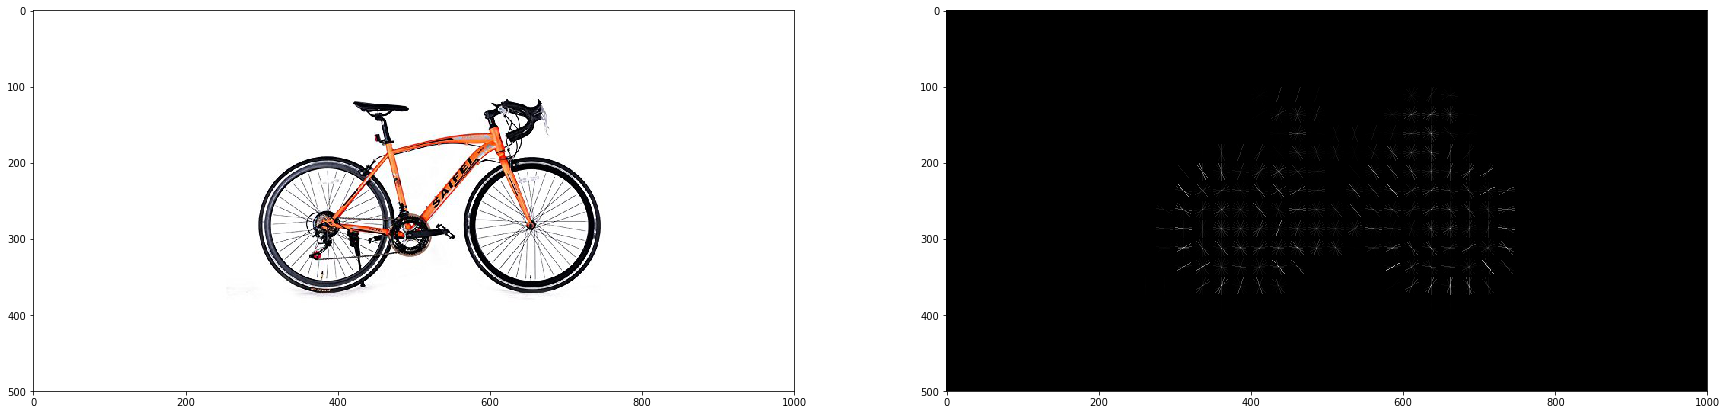

In [11]:
# Demonstartion
image = imread("bicycle.jpg")
gray_image = rgb2gray(image)
#plt.imshow(gray_image, cmap=plt.cm.gray)
plt.figure(figsize=(30, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
hog_feature, hog_image = calculate_hog(gray_image, N_p=25)
plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap=plt.cm.gray)
plt.savefig("figures/hog_image.jpg")